In [1]:
import pandas_datareader as pdr
from datetime import datetime,timedelta
from matplotlib.pyplot import plot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import SimpleRNNCell, RNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
end = datetime.today()
start = datetime(end.year-3,end.month,end.day)
df = pdr.get_data_yahoo(['BTC-USD'],start, end)
df = df.drop(['Volume','Adj Close'],axis=1)
print(df.shape)

(1093, 4)


In [3]:
print(df)

Attributes     Close      High       Low      Open
Symbols      ADA-USD   ADA-USD   ADA-USD   ADA-USD
Date                                              
2018-06-01  0.227742  0.229531  0.219242  0.222701
2018-06-02  0.228154  0.236761  0.225118  0.227700
2018-06-03  0.214012  0.231228  0.212290  0.228155
2018-06-04  0.220467  0.221728  0.204815  0.214247
2018-06-05  0.215721  0.220862  0.210708  0.220565
...              ...       ...       ...       ...
2021-05-28  1.406232  1.561741  1.335859  1.513623
2021-05-29  1.577279  1.688977  1.351820  1.404303
2021-05-30  1.742778  1.750620  1.527209  1.575644
2021-05-31  1.734753  1.779591  1.660549  1.738447
2021-06-02  1.770757  1.801339  1.722803  1.737954

[1093 rows x 4 columns]


In [4]:
df = df['Open']

<AxesSubplot:xlabel='Date'>

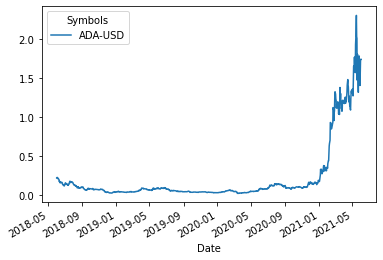

In [5]:
df.plot()

In [6]:
timestep = 64
lr = 0.001
epoch = 10000

In [7]:
data_train, data_test = train_test_split(df,test_size=0.2,shuffle=False)

In [8]:
scaler = MinMaxScaler().fit(data_train)
normalized_data_train = scaler.transform(data_train)
normalized_data_test = scaler.transform(data_test)

In [9]:
def create_timestep(data,timestep):
    feature = []
    target = []
    for i in range(timestep, data.shape[0]):
        feature.append(
            data[i - timestep : i]
        )
        target.append(
            data[i]
        )
    feature = np.array(feature, 'float32')
    target = np.array(target,'float32')
    return feature, target
X_train,y_train = create_timestep(normalized_data_train,timestep)
X_test,y_test = create_timestep(normalized_data_test,timestep)

In [10]:
layer = {
    'input': df.shape[1],
    'output': 1
}
input = tf.placeholder(tf.float32, shape=[None, timestep, layer['input']])
output = tf.placeholder(tf.float32 , shape=[None, layer['output']])

In [11]:
cell = SimpleRNNCell(10, 'relu')
rnn_layer = RNN(cell, dtype=tf.float32)
out_layer = Dense(layer['output'])

In [12]:
out_tensor = rnn_layer(input)
out_tensor = out_layer(out_tensor)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
loss = tf.reduce_mean(0.5 * ((out_tensor - output) ** 2))
train = tf.train.AdamOptimizer(lr).minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
saver = tf.train.Saver()

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_feed = {
        input: X_train,
        output: y_train
    }
    for i in range(epoch):
        sess.run(train, feed_dict = train_feed)
        if(i % 1000 == 0):
            print('Iteration : {} | Loss : {}'.format(i+1,sess.run(loss,                feed_dict=train_feed)))
    saver.save(sess,'./model.ckpt')


Iteration : 1 | Loss : 0.035694535821676254
Iteration : 1001 | Loss : 0.00016303763550240546
Iteration : 2001 | Loss : 0.00016162525571417063
Iteration : 3001 | Loss : 0.00016150172450579703
Iteration : 4001 | Loss : 0.0001614342472748831
Iteration : 5001 | Loss : 0.00016132347809616476
Iteration : 6001 | Loss : 0.00016118168423417956
Iteration : 7001 | Loss : 0.00015398100367747247
Iteration : 8001 | Loss : 0.00015371278277598321
Iteration : 9001 | Loss : 0.00015349402383435518


INFO:tensorflow:Restoring parameters from ./model.ckpt
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


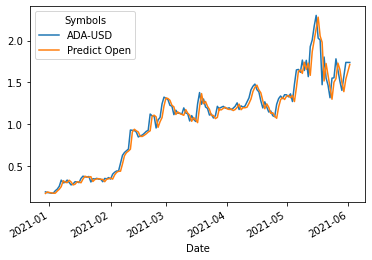

In [16]:
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    predict = sess.run(out_tensor,feed_dict={input:X_test})
    predict = scaler.inverse_transform(predict)
    new_df = data_test.iloc[timestep:, :]
    # new_df['Predict Close'] = predict[:,0]
    # new_df['Predict High'] = predict[:,1]
    # new_df['Predict Low'] = predict[:,2]
    new_df['Predict Open'] = predict

    new_df.plot()

In [22]:
print(predict)

[[0.17344351]
 [0.19100493]
 [0.18446548]
 [0.179996  ]
 [0.17548008]
 [0.17635278]
 [0.20164177]
 [0.22355899]
 [0.25495484]
 [0.32576296]
 [0.30733162]
 [0.30196247]
 [0.33111688]
 [0.3104534 ]
 [0.2751767 ]
 [0.28334215]
 [0.3115731 ]
 [0.31043416]
 [0.3004712 ]
 [0.34534064]
 [0.37876242]
 [0.3713214 ]
 [0.36628878]
 [0.37389708]
 [0.31579855]
 [0.33920366]
 [0.34700876]
 [0.350016  ]
 [0.34144846]
 [0.34124422]
 [0.31351477]
 [0.34359124]
 [0.34819576]
 [0.35732824]
 [0.34385478]
 [0.39347625]
 [0.42445302]
 [0.43770915]
 [0.43872532]
 [0.5262453 ]
 [0.6236083 ]
 [0.66111815]
 [0.6788453 ]
 [0.70201474]
 [0.90922004]
 [0.9399345 ]
 [0.9210747 ]
 [0.9068885 ]
 [0.8549728 ]
 [0.8541524 ]
 [0.8680804 ]
 [0.88521653]
 [0.9067869 ]
 [0.92156017]
 [1.0966518 ]
 [1.1079115 ]
 [1.0890002 ]
 [0.96330637]
 [1.0301881 ]
 [1.0788059 ]
 [1.2188483 ]
 [1.3144004 ]
 [1.3072001 ]
 [1.2859076 ]
 [1.2265196 ]
 [1.2074115 ]
 [1.1164693 ]
 [1.146539  ]
 [1.1275418 ]
 [1.1182259 ]
 [1.1063929 ]
 [1.17

In [36]:
def create_new_timestep(data,timestep):
    feature = []
    # for i in range(timestep, data.shape[0]):
    feature.append(
        data[- timestep : ]
    )
    feature = np.array(feature, 'float32')
    return feature

predict_time = 365
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    x = predict[-(timestep):]
    x = scaler.transform(x)
    list_data = []
    for i in range(predict_time):
        temp = create_new_timestep(x, timestep)
        predict_value = sess.run(out_tensor,feed_dict={input:temp})
        x = np.append(x, predict_value[-1])
        x = x.reshape(-1,1)
        list_data.append(predict_value[-1])
    print(np.array(list_data).shape)
    list_data = scaler.inverse_transform(list_data)
    print(list_data)
    new_plot = pd.DataFrame(data=list_data)
    

INFO:tensorflow:Restoring parameters from ./model.ckpt
(365, 1)
[[1.68725226]
 [1.67662387]
 [1.65293632]
 [1.63948837]
 [1.62550906]
 [1.6089102 ]
 [1.59270734]
 [1.57607497]
 [1.55897981]
 [1.54168639]
 [1.52418208]
 [1.5065133 ]
 [1.48873849]
 [1.4708922 ]
 [1.4530097 ]
 [1.43512271]
 [1.41725832]
 [1.39944164]
 [1.38169331]
 [1.36403271]
 [1.34647582]
 [1.32903722]
 [1.31172921]
 [1.29456276]
 [1.27754715]
 [1.26069025]
 [1.24399908]
 [1.22747976]
 [1.21113678]
 [1.19497423]
 [1.17899581]
 [1.16320356]
 [1.14760001]
 [1.13218654]
 [1.1169642 ]
 [1.10193339]
 [1.08709498]
 [1.07244849]
 [1.05799382]
 [1.0437298 ]
 [1.02965673]
 [1.01577255]
 [1.00207679]
 [0.98856778]
 [0.97524437]
 [0.96210537]
 [0.94914807]
 [0.93637246]
 [0.92377464]
 [0.91135522]
 [0.89910969]
 [0.88703836]
 [0.87513704]
 [0.86340525]
 [0.85184015]
 [0.84044048]
 [0.82920313]
 [0.81812693]
 [0.80720915]
 [0.79644804]
 [0.7858417 ]
 [0.77538785]
 [0.76508467]
 [0.75492984]
 [0.7449215 ]
 [0.73505762]
 [0.72533652

In [38]:
def get_year():
    global predict_time
    list_data = []
    time = datetime(datetime.today().year,datetime.today().month, datetime.today().day)
    for i in range(predict_time):
        time += timedelta(days=1)
        list_data.append(time.strftime('%Y-%m-%d'))
    return list(list_data)


<AxesSubplot:xlabel='Date'>

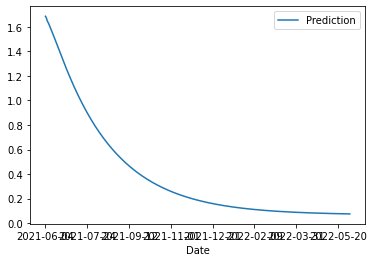

In [39]:
new_plot.columns = ['Prediction']
new_plot['Date'] = get_year()
new_plot.set_index('Date', inplace=True)
new_plot.plot()

In [40]:
print(new_plot['Prediction'])

Date
2021-06-04    1.687252
2021-06-05    1.676624
2021-06-06    1.652936
2021-06-07    1.639488
2021-06-08    1.625509
                ...   
2022-05-30    0.075162
2022-05-31    0.075033
2022-06-01    0.074906
2022-06-02    0.074781
2022-06-03    0.074658
Name: Prediction, Length: 365, dtype: float64


In [21]:
print(get_year())

['2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18', '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13', '2021